In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import f1_score,roc_auc_score,recall_score,precision_score,make_scorer,accuracy_score,roc_curve,confusion_matrix,classification_report

import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder


In [2]:
def plot_roc_curve(y_train_actual, train_pred_prob, y_test_actual, test_pred_prob, *args):
    '''
    Generate the train & test roc curve
    '''

    AUC_Train = roc_auc_score(y_train_actual, train_pred_prob)
    AUC_Test = roc_auc_score(y_test_actual, test_pred_prob)

    if len(args) == 0:
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        roc_plot(fpr, tpr, fpr_tst, tpr_tst)

    else:
        AUC_Valid = roc_auc_score(args[0], args[1])
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        print("Validation AUC = ", AUC_Valid)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        fpr_val, tpr_val, thresholds = roc_curve(args[0], args[1])
        roc_plot(fpr, tpr, fpr_tst, tpr_tst, fpr_val, tpr_val)

In [3]:
def roc_plot(fpr, tpr, fpr_tst, tpr_tst, *args):
    '''
    Generates roc plot
    '''

    fig = plt.plot(fpr, tpr, label='Train')
    fig = plt.plot(fpr_tst, tpr_tst, label='Test')

    if len(args) == 0:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    else:
        fig = plt.plot(args[0], args[1], label='Validation')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

In [4]:
Tdata = pd.read_csv(r"C:\Users\ganes\Downloads\churn (2).csv")

In [5]:
print('ROWS : ',Tdata.shape[0])
print('COLUMNS : ',Tdata.shape[1])

ROWS :  7043
COLUMNS :  21


In [6]:
def df_summary(df):
    df_U = df.nunique()
    df_M = df.isnull().sum()
    df_I = df.dtypes
    df_U = df_U.to_frame().reset_index()
    df_M = df_M.to_frame().reset_index()
    df_I = df_I.to_frame().reset_index()
    df_U = df_U.rename(columns = {0:'Unique Data'})
    df_M = df_M.rename(columns= {0: 'Missing Data'})
    df_I = df_I.rename(columns= {0: 'Data Types'})
    output = pd.merge(pd.merge(df_M,df_U,on='index'),df_I,on ='index')
    return output;

In [7]:
df_summary(Tdata)

,index,Missing Data,Unique Data,Data Types
0,customerID,0,7043,object
1,gender,0,2,object
2,SeniorCitizen,0,2,int64
3,Partner,0,2,object
4,Dependents,0,2,object
5,tenure,0,73,int64
6,PhoneService,0,2,object
7,MultipleLines,0,3,object
8,InternetService,0,3,object
9,OnlineSecurity,0,3,object


# Important points to note from above dataframe
* From Data types we can identify 2 integer ,1 float ,18 string variable are there in our data

* From Unique values

    1. 13 variable having binary & multi class
    2. We know that Customer ID has unique ness in the data
    3. All variable are looking good but Surprislingly amoung all the variable MonthlyIncome having many classes
   We will look into the variable more closely

In [8]:
Tdata.TotalCharges.head()

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: object

*  Seems the variables is wrongly classified as object data type .
* We will convert into Numerical`

In [9]:
Tdata.TotalCharges = pd.to_numeric(Tdata.TotalCharges,errors='coerce')
Tdata.TotalCharges.describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

* Lets call summary function again to cross check the adjusments

In [10]:
df_summary(Tdata)

,index,Missing Data,Unique Data,Data Types
0,customerID,0,7043,object
1,gender,0,2,object
2,SeniorCitizen,0,2,int64
3,Partner,0,2,object
4,Dependents,0,2,object
5,tenure,0,73,int64
6,PhoneService,0,2,object
7,MultipleLines,0,3,object
8,InternetService,0,3,object
9,OnlineSecurity,0,3,object


* After coverting to numerical we have identified that there are 11 missig oberverations are there for V18 variable.

* Lets Impute the missing values with the mean of the variable since it has only 11

In [11]:
Tdata['TotalCharges'].fillna((Tdata['TotalCharges'].mean()),inplace=True)
Tdata['TotalCharges'].isnull().sum()

0

* As we dicussed above we will drop the customer id column since it will not give much information for prediciton

In [12]:
Tdata.drop('customerID',axis = 1,inplace = True)
Tdata.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

# Lets separate Numerical columns and object columns seperatly

In [13]:
Num_cols = Tdata.select_dtypes(include=['float64','int64']).columns.tolist()
Cat_cols = Tdata.select_dtypes(include=['object']).columns.tolist()
print('Number columns : ', Num_cols, 'Catogarical columns: ',Cat_cols,sep = '\n')

Number columns : 
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Catogarical columns: 
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


* Lets see all the categorical & Numerical information one by one
* Numerical variable we can use describe function directly

In [14]:
Tdata[Num_cols].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


* We can see those values w.r.to Target data
* Lets plot these variable with target

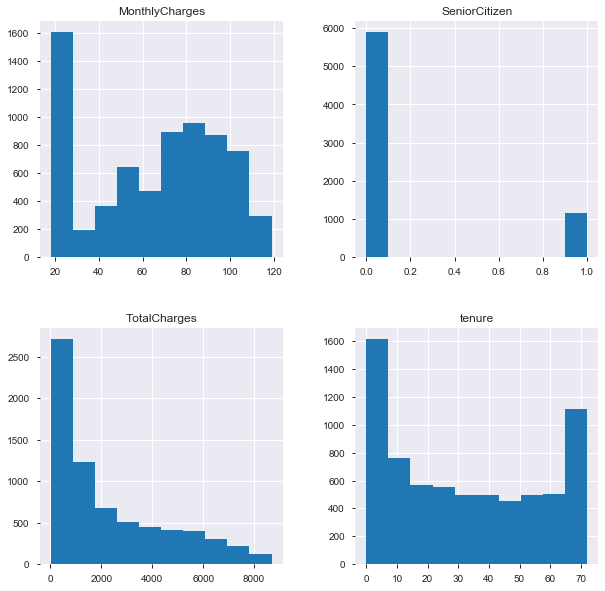

In [15]:
Tdata[Num_cols].hist(figsize =(10,10));

* Data is skewed in V17 & V18 variable

# Lets see the binaary and multiclass variables
  Creating function to see all the object data type variables using single function

In [16]:
def cat_col_desc(data):
    col_list = data.select_dtypes(include =['object']).columns.tolist()
    for i in col_list:
        print("Variable :", i)
        print("Count the unique values :",len(set(data[i])))
        print('Unique values : ',set(data[i]))
        print("==========================================================================")
            

In [17]:
cat_col_desc(Tdata)

Variable : gender
Count the unique values : 2
Unique values :  {'Female', 'Male'}
Variable : Partner
Count the unique values : 2
Unique values :  {'No', 'Yes'}
Variable : Dependents
Count the unique values : 2
Unique values :  {'No', 'Yes'}
Variable : PhoneService
Count the unique values : 2
Unique values :  {'No', 'Yes'}
Variable : MultipleLines
Count the unique values : 3
Unique values :  {'No phone service', 'No', 'Yes'}
Variable : InternetService
Count the unique values : 3
Unique values :  {'DSL', 'No', 'Fiber optic'}
Variable : OnlineSecurity
Count the unique values : 3
Unique values :  {'No internet service', 'No', 'Yes'}
Variable : OnlineBackup
Count the unique values : 3
Unique values :  {'No internet service', 'No', 'Yes'}
Variable : DeviceProtection
Count the unique values : 3
Unique values :  {'No internet service', 'No', 'Yes'}
Variable : TechSupport
Count the unique values : 3
Unique values :  {'No internet service', 'No', 'Yes'}
Variable : StreamingTV
Count the unique va

sns.countplot(x="Churn", hue="gender", data=Tdata)

In [18]:
Binary_class = Tdata[Cat_cols].nunique()[Tdata[Cat_cols].nunique() == 2].keys().tolist()
Multi_class = Tdata[Cat_cols].nunique()[Tdata[Cat_cols].nunique() > 2].keys().tolist()
print(Binary_class)
print(Multi_class)

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


# Look at Multi class variable distribution


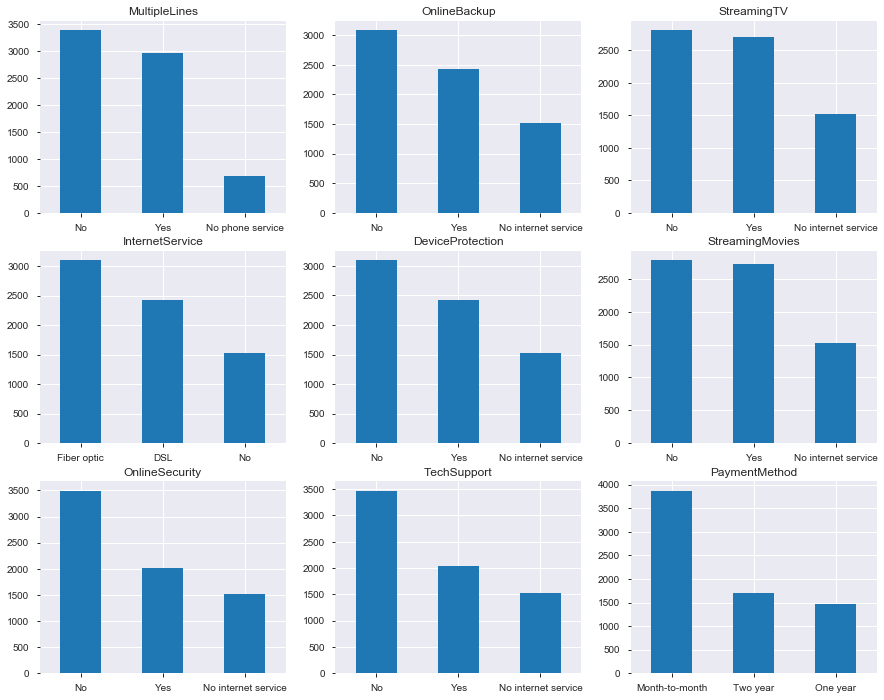

In [19]:
fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(Multi_class):
    if i < 3:
        ax = Tdata[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = Tdata[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = Tdata[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

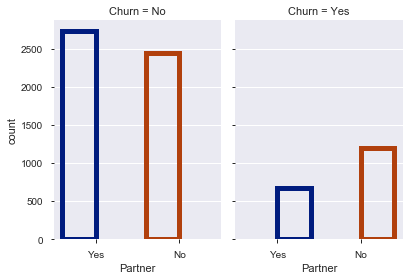

In [20]:
sns.catplot(x="Partner", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),
linewidth=5,edgecolor=sns.color_palette("dark", 5))

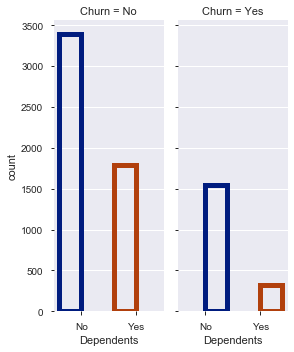

In [21]:
sns.catplot(x="Dependents", hue="Churn", col="Churn",data=Tdata, kind="count",height=5, aspect=.4,  facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 5))

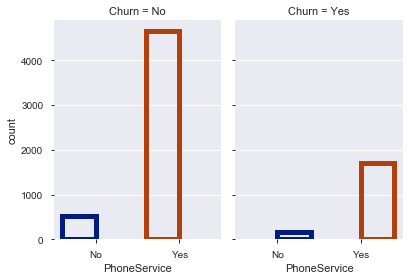

In [22]:
sns.catplot(x="PhoneService", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 5))

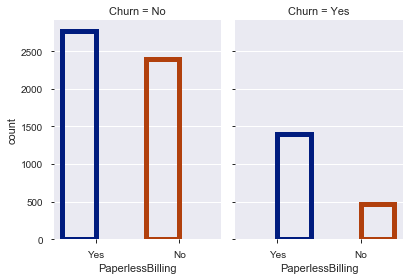

In [23]:
sns.catplot(x="PaperlessBilling", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 5))

# Tranforming the data

In [24]:
# Label encoding Binary columns
le  = LabelEncoder()
for i in Binary_class:
    Tdata[i] = le.fit_transform(Tdata[i])

In [25]:
Tdata[Binary_class].shape

(7043, 6)

In [26]:
Tdata[Num_cols].shape

(7043, 4)

In [27]:
# Split multi-class catergory columns as dummies
Tdata_Dummy = pd.get_dummies(Tdata[Multi_class])
Tdata_Dummy.head()

,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,1,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,1,0,1,0,0,0,0,1,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,1,0,1,0,0,1,...,1,0,0,1,0,0,0,0,1,0


In [28]:
New_df = pd.concat([Tdata[Num_cols],Tdata[Binary_class],Tdata_Dummy],axis = 1)
New_df.shape

(7043, 41)

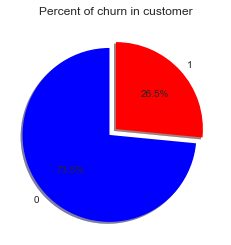

In [29]:
# Data to plot
labels =New_df['Churn'].value_counts(sort = True).index
sizes = New_df['Churn'].value_counts(sort = True)

colors = ["Blue","red"]
explode = (0.1,0)  # explode 1st slice
 
plt.pie(sizes, explode=explode, labels=labels, 
        colors=colors,autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Percent of churn in customer')
plt.show()

# Data Partition-2

In [30]:
X = New_df.drop('Churn',axis = 1)
y = New_df[['Churn']]

In [31]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 1)

In [32]:
print("The number of samples into the Train data is {}".format(x_train.shape[0]))
print("The number of samples into the Test data is {}".format(x_test.shape[0]))

The number of samples into the Train data is 5634
The number of samples into the Test data is 1409


# MODEL -2 GBM (Gradient Boosting)

In [33]:
# Define Model parameters to tune
model_parameters= {
    'n_estimators': [10,50,100,200,500,800],
    'max_depth': [3,8,16,32,None],
    'min_samples_leaf' : [np.random.randint(1,10)]
}

In [34]:
# GridSearch the parameters to find the best parameters
model = GradientBoostingClassifier(random_state= 10)

## random_state  -- The random number seed so that same random numbers are generated every time.
gscv_GBM = GridSearchCV(estimator=model,
                       param_grid=model_parameters,
                       cv = 5,
                       verbose=1,
                       n_jobs=-1,
                       scoring='f1')
gscv_GBM.fit(x_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 25.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [35]:
print('The best parameter are -', gscv_GBM.best_params_)


The best parameter are - {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 100}


In [36]:
# Re-fit the model with the best parameters
final_mod_GBM = GradientBoostingClassifier(**gscv_GBM.best_params_)
final_mod_GBM.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [37]:
# Prediction
train_pred = final_mod_GBM.predict(x_train)
test_pred = final_mod_GBM.predict(x_test)

In [38]:
# Confusion Matrix Train Data (2 Model)
from sklearn.metrics import confusion_matrix

In [39]:
confusion_matrix = confusion_matrix(y_train,
                                    train_pred)
print(confusion_matrix)

[[3779  334]
 [ 646  875]]


In [40]:
Accuracy_test=((3769+876)/(3769+876+344+645)*100)
Accuracy_test

82.44586439474618

 # Confusion Matrix Test Data (2 Model)

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,
                                    test_pred)
print(confusion_matrix)

[[940 121]
 [150 198]]


In [42]:
Accuracy_test=((938+201)/(938+201+147+123)*100)
Accuracy_test

80.8374733853797

In [43]:
print('Classification report for train data is : \n',
      classification_report(y_train, train_pred))
print('Classification report for test data is : \n',
      classification_report(y_test, test_pred))

Classification report for train data is : 
               precision    recall  f1-score   support

           0       0.85      0.92      0.89      4113
           1       0.72      0.58      0.64      1521

    accuracy                           0.83      5634
   macro avg       0.79      0.75      0.76      5634
weighted avg       0.82      0.83      0.82      5634

Classification report for test data is : 
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      1061
           1       0.62      0.57      0.59       348

    accuracy                           0.81      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.80      0.81      0.80      1409

